FER Training with Pre-trained Mini Xception Architecture

In [1]:
import os
import json
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Mini Xception model functions
import sys, os
sys.path.append(os.path.abspath('..'))  # move up one folder level to project_root
sys.path.append(os.path.abspath('../notebooks/FC110532_Haritha'))

from base_model.model import create_mini_xception, compile_model

#print("TensorFlow version:", tf.__version__)
#print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

2025-10-14 09:30:37.577935: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-14 09:30:37.803777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 09:30:43.493827: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Configuration

In [2]:
# Dataset paths
DATA_DIR = "../../../Data/images"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "validation")

# Training parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 25  # Transfer learning allows fewer epochs
EPOCHS_STAGE2 = 20
SEED = 42
NUM_CLASSES = 7

# Pre-trained weights path
PRETRAINED_WEIGHTS_PATH = "../../models/pretrained/mini_xception_pretrained_weights.h5"
USE_PRETRAINED = True  # If False → trains from scratch

# Save paths
MODEL_TAG = "mini_xception_fer_pretrained" 
SAVE_DIR = "../../../models"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}.keras")
BEST_MODEL_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}_best.keras")
CLASSMAP_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}_classes.json")
HISTORY_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}_history.json")

print("="*60)
print("FER TRAINING WITH TRANSFER LEARNING ")
print("="*60)
print(f"Data directory: {DATA_DIR}")
print(f"Using pre-trained weights: {USE_PRETRAINED}")
if USE_PRETRAINED:
    print(f"Pre-trained weights: {PRETRAINED_WEIGHTS_PATH}")
print(f"Model save path: {MODEL_PATH}")

FER TRAINING WITH TRANSFER LEARNING 
Data directory: ../../../Data/images
Using pre-trained weights: True
Pre-trained weights: ../../models/pretrained/mini_xception_pretrained_weights.h5
Model save path: ../../../models/mini_xception_fer_pretrained.keras


Define Data Generator Functions

In [3]:
def get_train_val_data_gen(folder_path, picture_size=48, batch_size=32, val_split=0.1, seed=42):
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split,
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    
    train_ds = datagen.flow_from_directory(
        folder_path,
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse',
        subset="training",
        seed=seed
    )
    
    val_ds = datagen.flow_from_directory(
        folder_path,
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse',
        subset="validation",
        seed=seed
    )
    
    return train_ds, val_ds

def get_test_data_gen(test_folder_path, picture_size=48, batch_size=32):
    """
    Test data generator 
    """
    datagen_test = ImageDataGenerator(rescale=1./255)
    test_ds = datagen_test.flow_from_directory(
        test_folder_path,
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )
    return test_ds

print("Data generator functions defined!")

Data generator functions defined!


Create Data Generators

In [4]:
train_generator, val_generator = get_train_val_data_gen(
    folder_path=TRAIN_DIR,
    picture_size=48,
    batch_size=BATCH_SIZE,
    val_split=0.1,
    seed=SEED
)

test_generator = get_test_data_gen(
    test_folder_path=TEST_DIR,
    picture_size=48,
    batch_size=BATCH_SIZE
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class labels: {list(train_generator.class_indices.keys())}")

# Save class mapping
class_map = train_generator.class_indices
with open(CLASSMAP_PATH, "w") as f:
    json.dump(class_map, f, indent=2)
print("Saved class mapping ->", CLASSMAP_PATH)

Found 25942 images belonging to 7 classes.
Found 2879 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Training samples: 25942
Validation samples: 2879
Test samples: 7066
Number of classes: 7
Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Saved class mapping -> ../../../models/mini_xception_fer_pretrained_classes.json


Build Mini Xception Model + Load Pre-trained Weights

In [5]:
print("\n" + "="*60)
print("BUILDING MODEL WITH TRANSFER LEARNING")
print("="*60)

# Create model
model = create_mini_xception(input_shape=(48, 48, 1), num_classes=train_generator.num_classes)

# Load pre-trained weights (if available)
if USE_PRETRAINED and os.path.exists(PRETRAINED_WEIGHTS_PATH):
    print(f"Loading pre-trained weights from: {PRETRAINED_WEIGHTS_PATH}")
    try:
        model.load_weights(PRETRAINED_WEIGHTS_PATH, by_name=True, skip_mismatch=True)
        print("Pre-trained weights loaded successfully! ")
    except Exception as e:
        print(f" Could not load pre-trained weights: {e}")
        print("Training from scratch instead.")
else:
    print("Training from scratch...")

# Compile model
model = compile_model(model)

model.summary()
print(f"Total parameters: {model.count_params():,}")


BUILDING MODEL WITH TRANSFER LEARNING


2025-10-14 09:31:36.227573: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training from scratch...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 48, 48, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 24, 24, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 12, 12, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 50,631 (197.78 KB)

 Trainable params: 49,223 (192.28 KB)

 Non-trainable params: 1,408 (5.50 KB)

Total parameters: 50,631


Define Callbacks

In [6]:
callbacks = [
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_accuracy",
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
]

print(" Callbacks defined!")

 Callbacks defined!


Stage 1 Training


STAGE 1 TRAINING (25 epochs)
 Transfer Learning active: faster convergence and higher accuracy expected.


/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.2177 - loss: 1.9780
Epoch 1: val_accuracy improved from -inf to 0.28031, saving model to ../../../models/mini_xception_fer_pretrained_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 704s 853ms/step - accuracy: 0.2178 - loss: 1.9778 - val_accuracy: 0.2803 - val_loss: 1.7578 - learning_rate: 0.0010
Epoch 2/25
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2912 - loss: 1.7324
Epoch 2: val_accuracy did not improve from 0.28031
811/811 ━━━━━━━━━━━━━━━━━━━━ 286s 352ms/step - accuracy: 0.2912 - loss: 1.7324 - val_accuracy: 0.2612 - val_loss: 1.9479 - learning_rate: 0.0010
Epoch 3/25
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3512 - loss: 1.6328
Epoch 3: val_accuracy improved from 0.28031 to 0.34977, saving model to ../../../models/mini_xception_fer_pretrained_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 1581s 2s/step - accuracy: 0.3512 - loss: 1.6328 - val_accuracy: 0.3498 - val_loss: 1.7120 - learning_rate: 0.0010
Ep

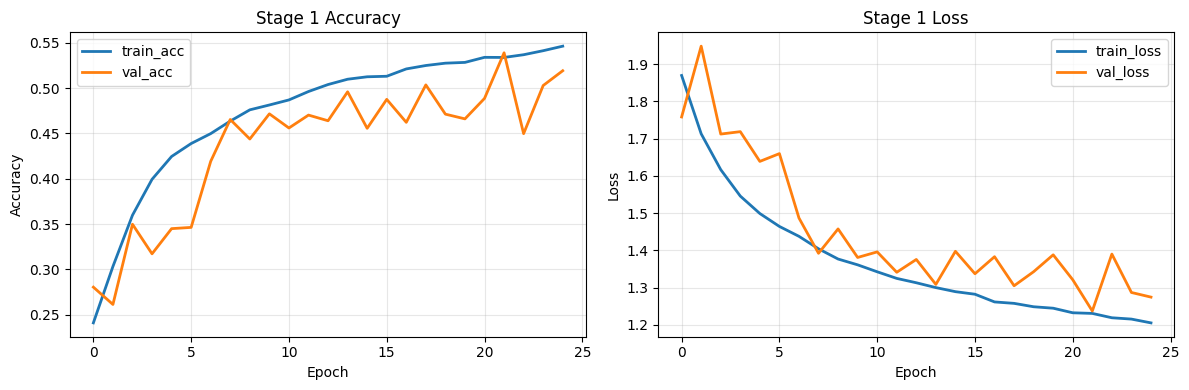

In [7]:
steps_per_epoch = max(1, math.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = max(1, math.ceil(val_generator.samples / val_generator.batch_size))

print("\n" + "="*60)
print(f"STAGE 1 TRAINING ({EPOCHS_STAGE1} epochs)")
print("="*60)
if USE_PRETRAINED:
    print(" Transfer Learning active: faster convergence and higher accuracy expected.")

history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)

# Plot Stage 1 results
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history_stage1.history["accuracy"], label="train_acc", linewidth=2)
plt.plot(history_stage1.history["val_accuracy"], label="val_acc", linewidth=2)
plt.title("Stage 1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history_stage1.history["loss"], label="train_loss", linewidth=2)
plt.plot(history_stage1.history["val_loss"], label="val_loss", linewidth=2)
plt.title("Stage 1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Stage 2 Fine-Tuning


STAGE 2 FINE-TUNING (20 epochs)
Epoch 1/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5577 - loss: 1.1890
Epoch 1: val_accuracy improved from 0.53908 to 0.54984, saving model to ../../../models/mini_xception_fer_pretrained_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 311s 375ms/step - accuracy: 0.5576 - loss: 1.1890 - val_accuracy: 0.5498 - val_loss: 1.1822 - learning_rate: 1.0000e-05
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.5509 - loss: 1.1977
Epoch 2: val_accuracy improved from 0.54984 to 0.55505, saving model to ../../../models/mini_xception_fer_pretrained_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 297s 366ms/step - accuracy: 0.5509 - loss: 1.1977 - val_accuracy: 0.5551 - val_loss: 1.1848 - learning_rate: 1.0000e-05
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5528 - loss: 1.1895
Epoch 3: val_accuracy improved from 0.55505 to 0.56304, saving model to ../../../models/mini_xception_fer_pretrained_best.keras
811/811 ━━━━━━━━━━━━━

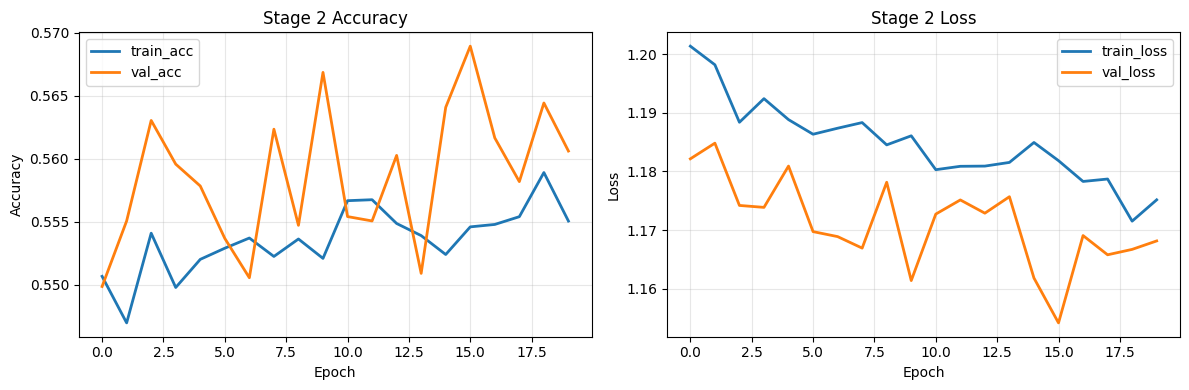

In [8]:
print("\n" + "="*60)
print(f"STAGE 2 FINE-TUNING ({EPOCHS_STAGE2} epochs)")
print("="*60)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)

# Plot Stage 2 results
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history_stage2.history["accuracy"], label="train_acc", linewidth=2)
plt.plot(history_stage2.history["val_accuracy"], label="val_acc", linewidth=2)
plt.title("Stage 2 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history_stage2.history["loss"], label="train_loss", linewidth=2)
plt.plot(history_stage2.history["val_loss"], label="val_loss", linewidth=2)
plt.title("Stage 2 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Save History

In [9]:
hist = {
    "stage1": {k: [float(x) for x in v] for k, v in history_stage1.history.items()},
    "stage2": {k: [float(x) for x in v] for k, v in history_stage2.history.items()},
    "used_pretrained": USE_PRETRAINED
}

with open(HISTORY_PATH, "w") as f:
    json.dump(hist, f, indent=2)

print(" Training history saved ->", HISTORY_PATH)

 Training history saved -> ../../../models/mini_xception_fer_pretrained_history.json


Save Model

In [10]:
print("\nLoading best model and saving final version...")

try:
    best_model = keras.models.load_model(BEST_MODEL_PATH)
    best_model.save(MODEL_PATH)
    print(" Model saved successfully ->", MODEL_PATH)
except Exception as e:
    print(f" Error: {e}")
    model.save(MODEL_PATH)
    print(" Saved current model ->", MODEL_PATH)


Loading best model and saving final version...
 Model saved successfully -> ../../../models/mini_xception_fer_pretrained.keras


Combined Curves

/tmp/ipykernel_743/2661269075.py:30: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/envs/ml-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


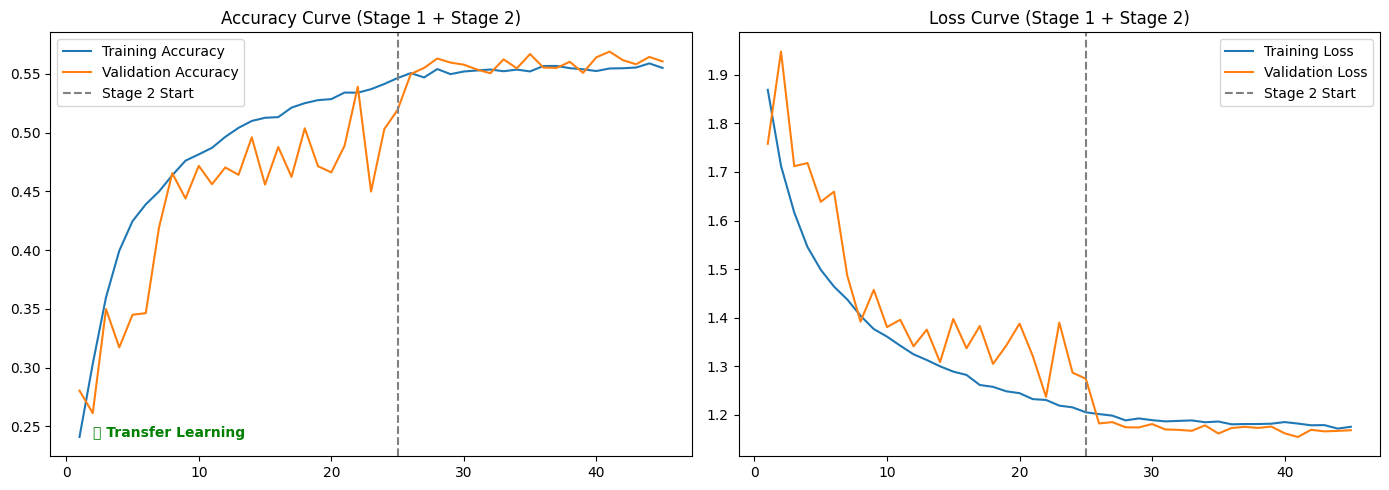

Best Validation Accuracy: 0.5689


In [11]:
def plot_combined_history(hist):
    stage1_epochs = len(hist['stage1']['accuracy'])
    stage2_epochs = len(hist['stage2']['accuracy'])

    all_epochs = list(range(1, stage1_epochs + stage2_epochs + 1))
    all_train_acc = hist['stage1']['accuracy'] + hist['stage2']['accuracy']
    all_val_acc = hist['stage1']['val_accuracy'] + hist['stage2']['val_accuracy']
    all_train_loss = hist['stage1']['loss'] + hist['stage2']['loss']
    all_val_loss = hist['stage1']['val_loss'] + hist['stage2']['val_loss']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(all_epochs, all_train_acc, label="Training Accuracy")
    plt.plot(all_epochs, all_val_acc, label="Validation Accuracy")
    plt.axvline(x=stage1_epochs, color="gray", linestyle="--", label="Stage 2 Start")

    if hist.get('used_pretrained', False):
        plt.text(2, min(all_train_acc), '🔥 Transfer Learning', fontsize=10, color='green', fontweight='bold')

    plt.title("Accuracy Curve (Stage 1 + Stage 2)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_epochs, all_train_loss, label="Training Loss")
    plt.plot(all_epochs, all_val_loss, label="Validation Loss")
    plt.axvline(x=stage1_epochs, color="gray", linestyle="--", label="Stage 2 Start")
    plt.title("Loss Curve (Stage 1 + Stage 2)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Best Validation Accuracy: {max(all_val_acc):.4f}")

plot_combined_history(hist)